In [1]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import gamma
from scipy.signal import find_peaks
import os
from scipy.stats import norm, chisquare
from sklearn.mixture import GaussianMixture

# Enable implicit multi-threading (optional)
ROOT.ROOT.EnableImplicitMT()

%matplotlib widget

In [2]:
DATA_PATH = './data/angles/'
FILES = os.listdir(DATA_PATH)

In [3]:
def get_arrays(a):
    x = globals()[f'angle{a}x']
    t = globals()[f'angle{a}t']
    return x, t

In [4]:
for file in FILES:
    if not file.endswith('.root'):
        continue

    # Load the ROOT file
    deg, other = file.split('deg')
    root_file = ROOT.TFile(os.path.join(DATA_PATH, file))

    exec(f"if 'angle{deg}x' not in locals(): angle{deg}x = []")
    exec(f"if 'angle{deg}t' not in locals(): angle{deg}t = []")
    tree = root_file.Get("electrons")
    df = ROOT.RDataFrame(tree)
    x_array = np.array(df.AsNumpy(['xf'])['xf']) * 10 # Convert to mm
    t_array = np.array(df.AsNumpy(['tf'])['tf']) # in ns
    exec(f"angle{deg}x.append(x_array)")
    exec(f"angle{deg}t.append(t_array)")

ANGLES = []

for a in range(60):
    if globals().get(f'angle{a}x') is not None: ANGLES.append(a)


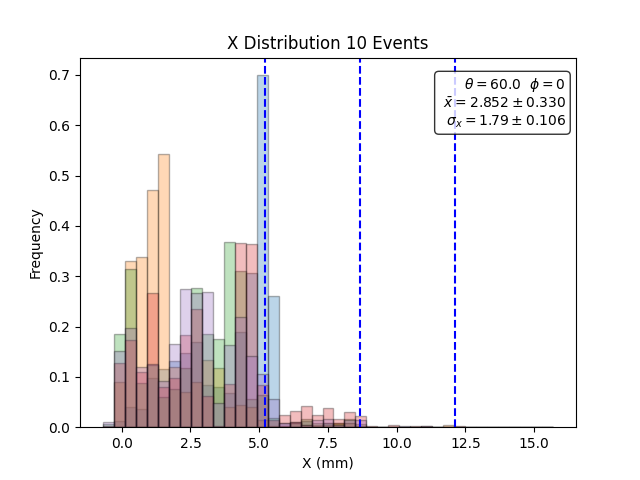

In [15]:
angle = 60

layer_1x = 3 * np.tan(np.radians(angle))
layer_2x = 5 * np.tan(np.radians(angle))
layer_3x = 7 * np.tan(np.radians(angle))

exec(f'array = angle{angle}x')
plt.figure()
all_data = np.concatenate(array)
bin_width = 0.4
bins = np.arange(all_data.min(), all_data.max() + bin_width, bin_width)
i = 0
for arr in array:
    plt.hist(arr, bins=bins, alpha=0.3, edgecolor='black', label=i, density=True)  # alpha controls transparency
    i+=1
stds = [np.std(i) for i in array]
std = np.mean(stds)
uncstd = np.std(stds)/np.sqrt(len(stds))

means = [np.mean(i) for i in array]
mean = np.mean(means)
uncmean = np.std(means)/np.sqrt(len(means))

plt.text(0.98, 0.95, f'$\\theta = {angle:.1f}$  $\\phi = 0$ \n $\\bar x = {mean:.3f} \\pm {uncmean:.3f}$\n $\\sigma_x = {std:.2f} \\pm {uncstd:.3f}$', transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.axvline(layer_1x, color='blue', linestyle='--', label='Layer 1')
plt.axvline(layer_2x, color='blue', linestyle='--', label='Layer 2')
plt.axvline(layer_3x, color='blue', linestyle='--', label='Layer 3')

plt.xlabel('X (mm)')
plt.ylabel('Frequency')
plt.title('X Distribution 10 Events')
# plt.legend()
plt.show()

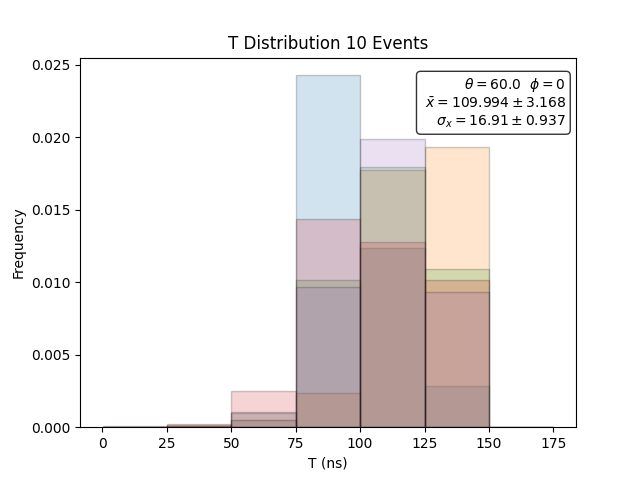

In [6]:
exec(f'array = angle{angle}t')
plt.figure()
all_data = np.concatenate(array)
bin_width = 25
bins = np.arange(all_data.min(), all_data.max() + bin_width, bin_width)
i = 0
for arr in array:
    plt.hist(arr, bins=bins, alpha=0.2, edgecolor='black', label=i, density=True)  # alpha controls transparency
    i+=1
stds = [np.std(i) for i in array]
std = np.mean(stds)
uncstd = np.std(stds)/np.sqrt(len(stds))

means = [np.mean(i) for i in array]
mean = np.mean(means)
uncmean = np.std(means)/np.sqrt(len(means))

plt.text(0.98, 0.95, f'$\\theta = {angle:.1f}$  $\\phi = 0$ \n $\\bar x = {mean:.3f} \\pm {uncmean:.3f}$\n $\\sigma_x = {std:.2f} \\pm {uncstd:.3f}$', transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.xlabel('T (ns)')
plt.ylabel('Frequency')
plt.title('T Distribution 10 Events')
# plt.legend()
plt.show()

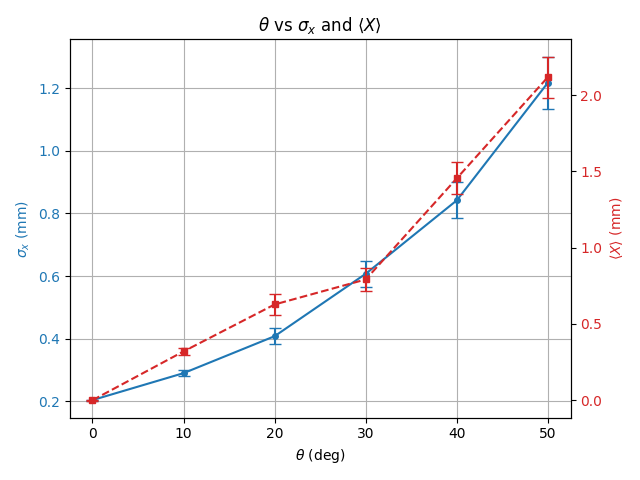

In [7]:
# Compute std means and uncertainties
stds = []
std_unc = []
for a in ANGLES:
    devs = [np.std(i) for i in get_arrays(a)[0]]
    stds.append(np.mean(devs))
    std_unc.append(np.std(devs) / np.sqrt(len(devs)))

# Compute mean means and uncertainties
means = []
mean_unc = []
for a in ANGLES:
    devs1 = [np.mean(i) for i in get_arrays(a)[0]]
    means.append(np.mean(devs1))
    mean_unc.append(np.std(devs1) / np.sqrt(len(devs1)))

# Create plot
fig, ax1 = plt.subplots()

# First y-axis: standard deviation
ax1.errorbar(ANGLES, stds, yerr=std_unc, fmt='o-', markersize=4, capsize=4, label=r'$\sigma_x$', color='tab:blue')
ax1.set_xlabel(r'$\theta$ (deg)')
ax1.set_ylabel(r'$\sigma_x$ (mm)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True)

# Second y-axis: mean
ax2 = ax1.twinx()
ax2.errorbar(ANGLES, means, yerr=mean_unc, fmt='s--', markersize=4, capsize=4, label=r'$\bar{X}$', color='tab:red')
ax2.set_ylabel(r'$\langle X \rangle$ (mm)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title(r'$\theta$ vs $\sigma_x$ and $\langle{X}\rangle$')
plt.tight_layout()
plt.show()

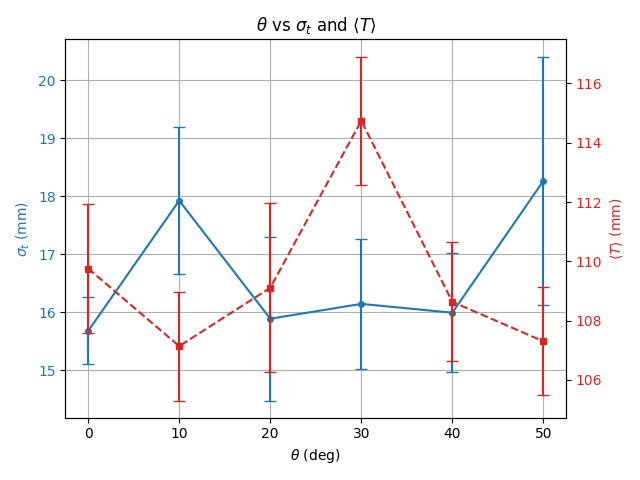

In [8]:
# Compute std means and uncertainties
stds = []
std_unc = []
for a in ANGLES:
    devs = [np.std(i) for i in get_arrays(a)[1]]
    stds.append(np.mean(devs))
    std_unc.append(np.std(devs) / np.sqrt(len(devs)))

# Compute mean means and uncertainties
means = []
mean_unc = []
for a in ANGLES:
    devs1 = [np.mean(i) for i in get_arrays(a)[1]]
    means.append(np.mean(devs1))
    mean_unc.append(np.std(devs1) / np.sqrt(len(devs1)))

# Create plot
fig, ax1 = plt.subplots()

# First y-axis: standard deviation
ax1.errorbar(ANGLES, stds, yerr=std_unc, fmt='o-', markersize=4, capsize=4, label=r'$\sigma_x$', color='tab:blue')
ax1.set_xlabel(r'$\theta$ (deg)')
ax1.set_ylabel(r'$\sigma_t$ (mm)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True)

# Second y-axis: mean
ax2 = ax1.twinx()
ax2.errorbar(ANGLES, means, yerr=mean_unc, fmt='s--', markersize=4, capsize=4, label=r'$\bar{X}$', color='tab:red')
ax2.set_ylabel(r'$\langle T \rangle$ (mm)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title(r'$\theta$ vs $\sigma_t$ and $\langle{T}\rangle$')
plt.tight_layout()
plt.show()

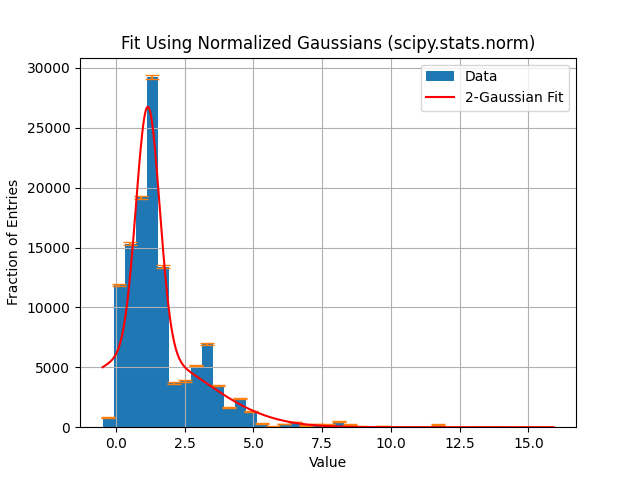

(np.float64(46726.92665320756), np.float64(798.7508829608131))


In [9]:

def chi_squared(observed, expected, uncertainty, dof=None):
    chi2 = np.sum((observed - expected)**2 / uncertainty**2)
    if dof is not None:
        return chi2, chi2 / dof
    return chi2

exec(f'data = angle{angle}x[1]')
plt.figure()
bin_width = 0.4
data_min = np.min(data)
data_max = np.max(data)
bins = np.arange(data_min, data_max + bin_width, bin_width)

def double_gaussian(x, a1, mu1, sigma1, a2, mu2, sigma2):
    return (a1 * np.exp(-(x - mu1)**2 / (2 * sigma1**2)) +
            a2 * np.exp(-(x - mu2)**2 / (2 * sigma2**2)))

# Use matplotlib's hist to get counts and bin edges (no plot)
counts, bin_edges = np.histogram(data, bins=bins)
c = []
b = []
# frequencies = counts / np.sum(counts)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

for i, (cc, bb) in enumerate(zip(counts, bin_centers)):
    if cc !=0:
        c.append(cc)
        b.append(bb)
counts = np.array(c)
bin_centers = np.array(b)
errs = np.sqrt(counts)


def n_gaussian_pdf(x, *params):
    n = len(params) // 3
    result = np.zeros_like(x)
    for i in range(n):
        a = params[3*i]
        mu = params[3*i + 1]
        sigma = params[3*i + 2]
        result += a * norm.pdf(x, loc=mu, scale=sigma)
    return result

def fit_n_gaussians(bin_centers, counts, n_modes, err):
    p0 = []
    for i in range(n_modes):
        a0 = max(counts)
        mu0 = 1 + i
        sigma0 = 1.0
        p0.extend([a0, mu0, sigma0])

    lower = [0, 0.01, 0.01] * n_modes
    upper = [np.inf, 10, np.inf] * n_modes

    params, _ = curve_fit(n_gaussian_pdf, bin_centers, counts, p0=p0, bounds=(lower, upper))
    return params

n_modes = 2
params = fit_n_gaussians(bin_centers, counts, n_modes, errs)

# Evaluate fit
x_fit = np.linspace(bin_edges[0], bin_edges[-1], 500)
y_fit = n_gaussian_pdf(x_fit, *params)

# Plot
plt.hist(data, bins=bins, label='Data')
plt.errorbar(bin_centers, counts, yerr=errs, fmt='o', markersize=0, capsize=5)
plt.plot(x_fit, y_fit, 'r-', label=f'{n_modes}-Gaussian Fit')
plt.xlabel('Value')
plt.ylabel('Fraction of Entries')
plt.title('Fit Using Normalized Gaussians (scipy.stats.norm)')
plt.legend()
plt.grid()
plt.show()

print(chi_squared(counts, n_gaussian_pdf(bin_centers, *params), uncertainty=errs, dof=len(counts)/n_modes*3))




In [76]:
errs

array([ 28.75760769, 109.01834708, 123.69316877, 138.55323887,
       170.92981016, 115.81882403,  60.7289058 ,  62.05642594,
        71.81921748,  83.39064696,  59.05929224,  40.4103947 ,
        48.72371086,  36.08323711,  17.40689519,   7.54983444,
        17.02938637,  20.76053949,  11.83215957,  15.71623365,
        14.96662955,  22.06807649,  15.29705854,   7.61577311,
         5.38516481,   8.30662386,   6.08276253,   4.79583152,
         3.16227766,   2.        ,  14.69693846,   5.91607978,
         1.41421356,   1.        ,   2.        ,   3.46410162,
         1.        ,   2.        ,   4.79583152])